# CSCI 544 — ARC-AGI Project Starter
*Group 45 — “Hint-on-Failure / Program-of-Thought”*  
*(Generated 2025-09-30 21:09:56)*

**What you get in this notebook**
- One-click setup for ARC-AGI-2 data
- Task visualizer and utilities
- A lightweight **Heuristic Solver** (rotations, flips, color remaps, cropping, largest-object ops, simple compositions)
- **Program-of-Thought (PoT) pipeline** that asks an LLM to write a Python `solve(grid)` program and safely executes it
- **Hint-on-Failure loop**: if heuristics fail, we auto-generate failure hints and re-prompt PoT
- Reproducible evaluation on the public **training** split and batched predictions for the **evaluation** split

> Tip: Run cells from top to bottom the first time. This notebook is Colab-friendly, but also runs locally.

In [ ]:
# %%capture
!pip -q install --upgrade pip
!pip -q install numpy pandas matplotlib pillow tqdm scikit-image networkx typer accelerate datasets einops python-dotenv
# Optional: for LLM integration (set OPENAI_API_KEY in the env variables cell below if you want to use PoT)
!pip -q install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.5 MB/s eta 0:00:00


In [ ]:
import os, sys, json, math, random, glob, time, textwrap, types, traceback, ast
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Optional, Callable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
from skimage.measure import label, regionprops
import networkx as nx

# Colab / inline plots
%matplotlib inline

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Where we'll clone ARC-AGI-2
DATA_ROOT = "/content/ARC-AGI-2"
TRAIN_DIR = os.path.join(DATA_ROOT, "data", "training")
EVAL_DIR  = os.path.join(DATA_ROOT, "data", "evaluation")

# We make sure numpy prints small arrays cleanly
np.set_printoptions(linewidth=120, threshold=300)

In [ ]:
# Clone ARC-AGI-2 (public training/evaluation tasks)
if not os.path.exists(DATA_ROOT):
    !git clone -q https://github.com/arcprize/ARC-AGI-2.git {DATA_ROOT}

assert os.path.isdir(TRAIN_DIR) and os.path.isdir(EVAL_DIR), "ARC-AGI-2 data folders not found after clone."
print("ARC-AGI-2 ready:", DATA_ROOT)
print("# train tasks:", len(glob.glob(os.path.join(TRAIN_DIR, "*.json"))))
print("# eval  tasks:", len(glob.glob(os.path.join(EVAL_DIR, "*.json"))))

ARC-AGI-2 ready: /content/ARC-AGI-2
# train tasks: 1000
# eval  tasks: 120


In [ ]:
COLORS = {
    0: (0, 0, 0),       # black
    1: (0, 0, 255),     # blue
    2: (0, 255, 0),     # green
    3: (255, 0, 0),     # red
    4: (255, 255, 0),   # yellow
    5: (255, 165, 0),   # orange
    6: (128, 0, 128),   # purple
    7: (160, 82, 45),   # brown
    8: (255, 192, 203), # pink
    9: (128, 128, 128)  # gray
}

def grid_to_image(grid: List[List[int]], scale: int = 20) -> Image.Image:
    '''Convert ARC grid (H x W ints 0..9) to a PIL image for display.'''
    h, w = len(grid), len(grid[0])
    img = Image.new("RGB", (w, h))
    px = img.load()
    for y in range(h):
        for x in range(w):
            px[x, y] = COLORS[int(grid[y][x])]
    if scale != 1:
        img = img.resize((w*scale, h*scale), Image.NEAREST)
    return img

def show_task(task: Dict[str, Any], scale: int = 20, max_pairs: int = 3):
    '''Visualize a task's train pairs and test inputs/outputs (if available).'''
    train = task["train"]
    test  = task["test"]
    nrows = max(len(train), len(test))
    ncols = 3  # input | -> | output
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3))
    if nrows == 1:
        axes = np.array([axes])
    for r in range(nrows):
        if r < len(train):
            _in  = grid_to_image(train[r]["input"], scale=scale)
            _out = grid_to_image(train[r]["output"], scale=scale)
            axes[r,0].imshow(_in);  axes[r,0].set_title("train input");  axes[r,0].axis("off")
            axes[r,2].imshow(_out); axes[r,2].set_title("train output"); axes[r,2].axis("off")
        else:
            axes[r,0].axis("off"); axes[r,2].axis("off")
        if r < len(test):
            _tin = grid_to_image(test[r]["input"], scale=scale)
            axes[r,1].imshow(_tin); axes[r,1].set_title("test input"); axes[r,1].axis("off")
        else:
            axes[r,1].axis("off")
    plt.tight_layout()
    plt.show()

def load_task(path: str) -> Dict[str, Any]:
    with open(path, "r") as f:
        return json.load(f)

def list_task_paths(split_dir: str) -> List[str]:
    return sorted(glob.glob(os.path.join(split_dir, "*.json")))

def grid_equal(a: List[List[int]], b: List[List[int]]) -> bool:
    return np.array_equal(np.array(a, dtype=int), np.array(b, dtype=int))

In [ ]:
# ---- Grid transforms ----

def rotate(grid, k=1):
    arr = np.array(grid, dtype=int)
    arr = np.rot90(arr, k=k)
    return arr.tolist()

def flip_h(grid):
    arr = np.array(grid, dtype=int)
    return np.fliplr(arr).tolist()

def flip_v(grid):
    arr = np.array(grid, dtype=int)
    return np.flipud(arr).tolist()

def transpose(grid):
    arr = np.array(grid, dtype=int)
    return arr.T.tolist()

def dominant_color(grid):
    vals, counts = np.unique(np.array(grid, dtype=int), return_counts=True)
    return int(vals[np.argmax(counts)])

def color_remap_by_majority(inp, out):
    '''Find a simple color->color mapping that explains many cells; fallback to identity for others.'''
    inp_arr, out_arr = np.array(inp, dtype=int), np.array(out, dtype=int)
    if inp_arr.shape != out_arr.shape:
        return {} # Return empty mapping if shapes don't match

    mapping = {c: c for c in range(10)}
    for c in range(10):
        mask = (inp_arr == c)
        if mask.sum() == 0:
            continue
        tgt_vals, tgt_counts = np.unique(out_arr[mask], return_counts=True)
        mapping[c] = int(tgt_vals[np.argmax(tgt_counts)])
    return mapping

def apply_color_map(grid, mapping: Dict[int,int]):
    arr = np.array(grid, dtype=int)
    res = arr.copy()
    for c_from, c_to in mapping.items():
        res[arr == c_from] = c_to
    return res.tolist()

def crop_to_nonzero(grid):
    arr = np.array(grid, dtype=int)
    ys, xs = np.where(arr != 0)
    if len(ys) == 0:
        return [[0]]
    y0, y1 = ys.min(), ys.max()+1
    x0, x1 = xs.min(), xs.max()+1
    return arr[y0:y1, x0:x1].tolist()

def paste_center(bg, fg):
    bg_arr = np.array(bg, dtype=int)
    fg_arr = np.array(fg, dtype=int)
    H, W   = bg_arr.shape
    h, w   = fg_arr.shape
    y0 = max((H - h)//2, 0)
    x0 = max((W - w)//2, 0)
    res = bg_arr.copy()
    mask = (fg_arr != 0)
    res[y0:y0+h, x0:x0+w][mask] = fg_arr[mask]
    return res.tolist()

def largest_object(grid):
    '''Return the largest connected component (4-connectivity) as its tight crop, colors preserved, background 0.'''
    arr = np.array(grid, dtype=int)
    mask = (arr != 0).astype(int)
    if mask.sum() == 0:
        return [[0]]
    lbl = label(mask, connectivity=1)
    props = regionprops(lbl)
    if not props:
        return [[0]]
    comp = max(props, key=lambda p: p.area)
    minr, minc, maxr, maxc = comp.bbox
    return arr[minr:maxr, minc:maxc].tolist()

def identity(grid): return [row[:] for row in grid]

# registry of parameterized transforms to search over
SIMPLE_TRANSFORMS = [
    ("identity", lambda grid: identity(grid)),
    ("rot90",    lambda grid: rotate(grid, 1)),
    ("rot180",   lambda grid: rotate(grid, 2)),
    ("rot270",   lambda grid: rotate(grid, 3)),
    ("flip_h",   lambda grid: flip_h(grid)),
    ("flip_v",   lambda grid: flip_v(grid)),
    ("transpose",lambda grid: transpose(grid)),
    ("crop_nonzero", lambda grid: crop_to_nonzero(grid)),
    ("largest_object", lambda grid: largest_object(grid)),
    # paste center largest object onto empty background
    ("largest_obj_centered", lambda grid: paste_center(np.zeros_like(np.array(grid)), largest_object(grid))),
]

def compose(f, g):
    return lambda x: f(g(x))

def name_compose(n1, n2):
    return f"{n1} ∘ {n2}"

def transforms_depth2():
    out = []
    for n1, f1 in SIMPLE_TRANSFORMS:
        for n2, f2 in SIMPLE_TRANSFORMS:
            out.append((name_compose(n1, n2), compose(f1, f2)))
    return out

DEPTH1 = SIMPLE_TRANSFORMS
DEPTH2 = transforms_depth2()

In [ ]:
@dataclass
class HeuristicProgram:
    name: str
    fn: Callable[[List[List[int]]], List[List[int]]]

class HeuristicSolver:
    def __init__(self, allow_color_map=True, allow_compositions=True):
        self.allow_color_map = allow_color_map
        self.allow_compositions = allow_compositions

    def _candidate_programs(self):
        cands = [HeuristicProgram(n, f) for n, f in DEPTH1]
        if self.allow_compositions:
            cands += [HeuristicProgram(n, f) for n, f in DEPTH2]
        return cands

    def _fits_all_pairs(self, prog: HeuristicProgram, pairs: List[Dict[str, Any]]) -> bool:
        try:
            for p in pairs:
                pred = prog.fn(p["input"])
                if not grid_equal(pred, p["output"]):
                    return False
            return True
        except Exception:
            return False

    def _try_color_map(self, pairs: List[Dict[str, Any]]):
        '''If a single color permutation explains all pairs, return it.'''
        mapping = color_remap_by_majority(pairs[0]["input"], pairs[0]["output"])
        for p in pairs:
            trial = apply_color_map(p["input"], mapping)
            if not grid_equal(trial, p["output"]):
                return None
        return mapping

    def fit(self, train_pairs: List[Dict[str, Any]]) -> Optional[HeuristicProgram]:
        # 1) try pure color remap
        if self.allow_color_map:
            m = self._try_color_map(train_pairs)
            if m is not None:
                return HeuristicProgram(f"color_map:{m}", lambda grid: apply_color_map(grid, m))

        # 2) try library transforms (depth 1 & 2)
        for cand in self._candidate_programs():
            if self._fits_all_pairs(cand, train_pairs):
                return cand

        # 3) fallback None
        return None

    def predict(self, program: HeuristicProgram, grid: List[List[int]]) -> List[List[int]]:
        return program.fn(grid)

In [ ]:
def diff_summary(a: List[List[int]], b: List[List[int]]) -> str:
    '''Describe how a prediction differs from the target.'''
    A, B = np.array(a, dtype=int), np.array(b, dtype=int)
    if A.shape != B.shape:
        return f"Shape mismatch: predicted {A.shape}, expected {B.shape}."
    mism = (A != B)
    n = mism.sum()
    if n == 0:
        return "Exact match."
    # basic stats
    pos = np.argwhere(mism)
    ys, xs = pos[:,0], pos[:,1]
    return (
        f"{n} cells differ. Pred dominant color={dominant_color(a)}, "
        f"Target dominant color={dominant_color(b)}. "
        f"Diff bbox: y[{ys.min()}..{ys.max()}], x[{xs.min()}..{xs.max()}]."
    )

def make_hint(train_pairs: List[Dict[str, Any]]) -> str:
    '''Generate a hint by comparing simple baselines to ground truth.'''
    hints = []
    for i, p in enumerate(train_pairs):
        inp, out = p["input"], p["output"]
        for name, fn in SIMPLE_TRANSFORMS[:6]:
            pred = fn(inp)
            if grid_equal(pred, out):
                return f"For example pair {i}, applying '{name}' to the input yields the output exactly. Consider implementing that."
            hints.append(f"Pair {i} with '{name}': {diff_summary(pred, out)}")
    return " | ".join(hints[:5])

In [ ]:
import os
import openai

# Optional: Set OPENAI_API_KEY in the cell below. If not set, PoT mode will be skipped.
OPENAI_MODEL = os.environ.get("OPENAI_MODEL", "gpt-4o-mini")  # change if you prefer
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY", None)
if OPENAI_API_KEY:
    openai.api_key = OPENAI_API_KEY

POT_SYSTEM_MSG = '''You are a Python code-writing assistant.
You will receive 1) few-shot ARC grid transformations as JSON of train pairs, and 2) a test input grid.
Write a *pure Python* function `def solve(grid): ...` that transforms the input grid to the desired output.
- The grid is a list of lists of ints in 0..9.
- Only use Python stdlib (no external imports).
- Do not print; return a new grid (list of lists of ints).
- Keep runtime < 1s for 30x30 grids.
- Prefer deterministic logic derived from the examples (rotations, flips, color mapping, crops, connected components, symmetry, etc.).
- Avoid brute force over many possibilities.
- IMPORTANT: Do not include any code that reads files or network or uses randomness.
'''

def pot_prompt(train_pairs: List[Dict[str, Any]], test_input: List[List[int]], extra_hint: Optional[str] = None) -> str:
    payload = {
        "train": train_pairs,
        "test_input": test_input,
        "note": extra_hint or ""
    }
    return "Solve the transformation by implementing `solve(grid)`.\n\n" + json.dumps(payload, indent=2)

def call_openai(messages: List[Dict[str,str]], temperature: float = 0.2, max_tokens: int = 1200) -> Optional[str]:
    if not OPENAI_API_KEY:
        return None
    try:
        resp = openai.ChatCompletion.create(
            model=OPENAI_MODEL,
            messages=messages,
            temperature=temperature,
            max_tokens=max_tokens,
        )
        return resp["choices"][0]["message"]["content"]
    except Exception as e:
        print("OpenAI error:", e)
        return None

In [ ]:
SAFE_BUILTINS = {
    "range": range, "len": len, "min": min, "max": max, "sum": sum, "abs": abs,
    "enumerate": enumerate, "zip": zip, "sorted": sorted, "list": list, "set": set, "dict": dict,
    "all": all, "any": any
}

def extract_solve_fn(code: str) -> Optional[Callable]:
    '''
    Execute the provided code in a restricted namespace and return solve().
    Reject code that imports modules or uses __...__ attributes.
    '''
    if "import " in code or "__" in code:
        return None
    mod = types.ModuleType("pot_user_code")
    g = {"__builtins__": SAFE_BUILTINS}
    l = {}
    try:
        exec(compile(code, "<pot>", "exec"), g, l)
    except Exception as e:
        print("Compile/exec error:", e)
        return None
    solve = l.get("solve") or g.get("solve")
    if callable(solve):
        return solve
    return None

def run_pot_once(train_pairs: List[Dict[str, Any]], test_grid: List[List[int]], hint: Optional[str] = None) -> Optional[List[List[int]]]:
    prompt = pot_prompt(train_pairs, test_grid, extra_hint=hint)
    msg = [
        {"role": "system", "content": POT_SYSTEM_MSG},
        {"role": "user", "content": prompt}
    ]
    content = call_openai(msg)
    if not content:
        return None
    # naive parse: find code block with def solve
    code = None
    if "```" in content:
        parts = content.split("```")
        for i in range(1, len(parts), 2):
            if "def solve" in parts[i]:
                code = parts[i]
                break
        if code and code.strip().startswith("python"):
            code = code.strip()[len("python"):].lstrip()
    else:
        code = content

    fn = extract_solve_fn(code or "")
    if fn is None:
        return None
    try:
        out = fn(test_grid)
        assert isinstance(out, list) and all(isinstance(r, list) for r in out), "solve() must return list[list[int]]"
        return out
    except Exception as e:
        print("Runtime error:", e)
        return None

In [ ]:
class HybridSolver:
    def __init__(self, max_pot_attempts: int = 2):
        self.heur = HeuristicSolver()
        self.max_pot_attempts = max_pot_attempts

    def fit(self, train_pairs: List[Dict[str, Any]]) -> Dict[str, Any]:
        result = {"mode": None, "program": None}
        # 1) heuristic fit
        prog = self.heur.fit(train_pairs)
        if prog is not None:
            result["mode"] = "heuristic"
            result["program"] = prog
            return result

        # 2) fallback: leave to PoT at predict-time (we'll store hints)
        result["mode"] = "pot"
        result["hint"] = make_hint(train_pairs)
        return result

    def predict(self, model_state: Dict[str, Any], grid: List[List[int]], train_pairs: List[Dict[str, Any]]) -> Optional[List[List[int]]]:
        if model_state["mode"] == "heuristic":
            return self.heur.predict(model_state["program"], grid)

        # PoT route
        hint = model_state.get("hint")
        out = None
        for attempt in range(self.max_pot_attempts):
            out = run_pot_once(train_pairs, grid, hint=hint)
            if out is not None:
                return out
            # escalate hint
            if train_pairs:
                hint2 = f"{hint} | Additional note: consider shape & color statistics; prioritize connected components and symmetry."
            else:
                hint2 = hint
            hint = hint2
        return out

In [ ]:
def solve_task_on_train(task: Dict[str, Any], solver: HybridSolver) -> Tuple[bool, Dict[str, Any]]:
    train_pairs = task["train"]
    state = solver.fit(train_pairs)

    # validate on train pairs
    ok = True
    for p in train_pairs:
        pred = solver.predict(state, p["input"], train_pairs)
        if pred is None or not grid_equal(pred, p["output"]):
            ok = False
            break
    return ok, state

def solve_task_on_test(task: Dict[str, Any], solver: HybridSolver, state: Dict[str, Any]) -> List[List[List[int]]]:
    outs = []
    for p in task["test"]:
        pred = solver.predict(state, p["input"], task["train"])
        outs.append(pred if pred is not None else [[0]])
    return outs

def evaluate_on_training_subset(n_tasks: int = 50, seed: int = 42):
    paths = list_task_paths(TRAIN_DIR)
    random.Random(seed).shuffle(paths)
    paths = paths[:n_tasks]
    solver = HybridSolver()
    solved = 0
    for path in tqdm(paths, desc="Training-eval"):
        task = load_task(path)
        ok, _state = solve_task_on_train(task, solver)
        solved += int(ok)
    print(f"Solved {solved}/{len(paths)} = {solved/len(paths):.1%} (train pairs exact match)")

In [ ]:
def batch_predict_evaluation(out_path: str = "/content/arc_eval_predictions.jsonl", limit: Optional[int] = None):
    eval_paths = list_task_paths(EVAL_DIR)
    if limit:
        eval_paths = eval_paths[:limit]
    solver = HybridSolver()
    n = 0
    with open(out_path, "w") as f:
        for path in tqdm(eval_paths, desc="Eval-predict"):
            task_id = os.path.splitext(os.path.basename(path))[0]
            task = load_task(path)
            _ok, state = solve_task_on_train(task, solver)  # fit on train pairs
            preds = solve_task_on_test(task, solver, state)
            rec = {"task_id": task_id, "predictions": preds}
            f.write(json.dumps(rec) + "\n")
            n += 1
    print(f"Wrote predictions for {n} tasks to {out_path}")
    return out_path

Sample task: /content/ARC-AGI-2/data/training/aa18de87.json


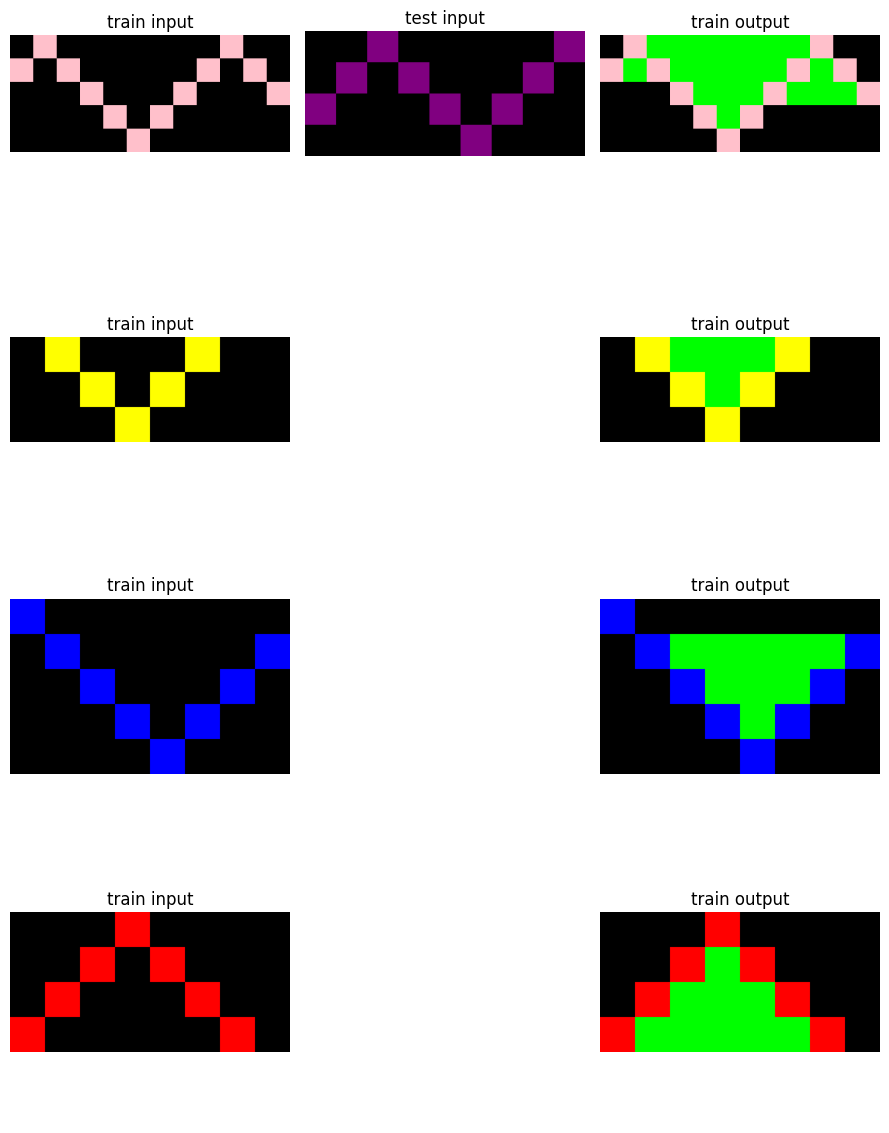

Train pairs solved? False | Mode: pot
Test #0 predicted grid shape: (1, 1)


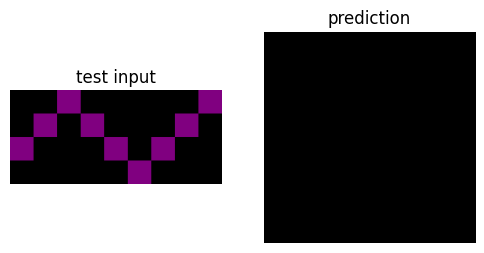

In [ ]:
# ===== Quickstart =====
# 1) Visualize a random training task
train_paths = list_task_paths(TRAIN_DIR)
sample_path = random.choice(train_paths)
print("Sample task:", sample_path)
task = load_task(sample_path)
show_task(task, scale=24)

# 2) Try to solve with Hybrid solver
solver = HybridSolver()
ok, state = solve_task_on_train(task, solver)
print("Train pairs solved?", ok, "| Mode:", state.get("mode"))
# 3) Predict test output(s) for this task
preds = solve_task_on_test(task, solver, state)
for i, p in enumerate(preds):
    print(f"Test #{i} predicted grid shape:", np.array(p).shape)
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(grid_to_image(task["test"][i]["input"])); plt.title("test input"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(grid_to_image(p)); plt.title("prediction"); plt.axis("off")
    plt.show()

In [ ]:
# Set your keys here in Colab before running PoT:
# import os
# os.environ["OPENAI_API_KEY"] = "sk-..."
# os.environ["OPENAI_MODEL"] = "gpt-4o-mini"
# After setting, re-run the PoT cells.

In [ ]:
# Try a small benchmark on 50 random training tasks
evaluate_on_training_subset(n_tasks=50, seed=SEED)

Training-eval:   0%|          | 0/50 [00:00<?, ?it/s]

Solved 1/50 = 2.0% (train pairs exact match)


In [ ]:
# Create predictions for the public evaluation split (limit for a smoke test)
out_file = batch_predict_evaluation(out_path="/content/arc_eval_predictions.jsonl", limit=5)
out_file

Eval-predict:   0%|          | 0/5 [00:00<?, ?it/s]

Wrote predictions for 5 tasks to /content/arc_eval_predictions.jsonl


'/content/arc_eval_predictions.jsonl'

In [17]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive
